In [1]:
#importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
import sklearn.model_selection as model_selection
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
%matplotlib inline

In [2]:
# Importing the "cleaned dataset" from the outliars detection file
monthly_data = pd.read_csv('monthly_data_cleaned.csv', index_col = 'date',infer_datetime_format=True)
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data.Commodity = monthly_data.Commodity.str.lower()
monthly_data.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price
date,,,,,,,,
2014-09-01,Kurdwadi,sorgum(jawar),2014,September,454,1353,2610,1981
2014-09-01,Satara,ladies finger,2014,September,128,2435,3261,2848
2014-09-01,Satara,potato,2014,September,2988,2175,2488,2331
2014-09-01,Satara,ginger (fresh),2014,September,199,3438,4813,4125
2014-09-01,Satara,ground nut pods (dry),2014,September,1,3000,4000,3500


In [3]:
len(monthly_data)

62426

In [4]:
#setting the frequency of data as "Monthly frequency"
monthly_data = monthly_data.to_period(freq='M')

In [5]:
#Function for ACF and PACF plots
def descriptive_plots(series,lags):
    title_1 = 'Autocorrelation plot'
    plot_acf(series,title=title_1,lags=lags);
    title_2 ='Partial Autocorrelation'
    plot_pacf(series,title=title_2,lags=lags);

In [6]:
#Function for Augmented Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    #print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [7]:
#Fitting the ARIMA or SARIMAX on the desired timeseries
def train_test_(dataframe):
    #print(dataframe)
    start = int(len(dataframe)*0.75)
    #print(start)
    train = dataframe.iloc[:start]
    test = dataframe.iloc[start:]
    
    #Enter the parameters of ARIMA
    
    p = int(input("enter value of p :" ))
    d = int(input("enter value of d :" ))
    q = int(input("enter value of q :" ))
    
    #Choose ARIMA or SARIMAX for fitting on the timeseries
    
    choice = input("choose ARIMA OR SARIMAX :")
    if choice=='ARIMA':
        model = ARIMA(dataframe['modal_price'],order=(p,d,q))
        results = model.fit()
        print(results.summary())
    else:
        P = int(input("enter value of P :" ))
        D = int(input("enter value of D :" ))
        Q = int(input("enter value of Q :" ))
        m = int(input("enter value of m :" ))
        model = SARIMAX(dataframe['modal_price'],order=(p,d,q), seasonal_order=(P,D,Q,m))
        results = model.fit()
        print(results.summary())
    
    start_=len(train)
    end=len(train)+len(test)-1
    if d==0:
        predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA Predictions')
    else:
        predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')
    # Compare predictions to expected values
    
    for i in range(len(predictions)):
        print(f"predicted={predictions[i]:<11.10}, expected={dataframe['modal_price'][i]}")
    # Plot predictions against known values
    title = 'APMC commodity data'
    ylabel='Modal Price'
    xlabel='Time' # we don't really need a label here
              
    #Shifting the timeseries by 1 time period index
    ax = test[['modal_price']].shift(1).plot(legend=True,figsize=(12,6),title=title)
    predictions.plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    
    #Calculating MSE
    error = mean_squared_error(test['modal_price'], predictions)
    print(f'MSE Error for {choice}: {error:11.10}')
              
    
    #Calculating RMSE
    error = rmse(test['modal_price'], predictions)
    print(f'RMSE Error for {choice}: {error:11.10}')


In [8]:
# "Dataplot" is our function from which we will call all our required functions
def dataplot(apmc,commodity):
    timeseries = monthly_data[(monthly_data.APMC == apmc) & (monthly_data.Commodity == commodity)].modal_price
    df = pd.DataFrame(timeseries)
    df.plot(figsize = (12,5))
    #print(df.shape)
    adf_test(timeseries)
    arima_parameters(timeseries)
    lags = input("enter the number of lags for acf & pacf plot")
    descriptive_plots(timeseries,lags)
    train_test_(df)
    

In [9]:
#Auto ARIMA function implemented
def arima_parameters(series):
    stepwise_fit = auto_arima(series, start_p=1, start_q=1,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise
    print(stepwise_fit.summary())

Enter an APMC: Satara
Enter a relevant commodity: potato
ADF test statistic      -2.144781
p-value                  0.226893
# lags used              0.000000
# observations          26.000000
critical value (1%)     -3.711212
critical value (5%)     -2.981247
critical value (10%)    -2.630095
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=251.950, BIC=253.366, Fit time=0.008 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=239.057, BIC=241.889, Fit time=0.229 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=249.952, BIC=250.660, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=239.385, BIC=2

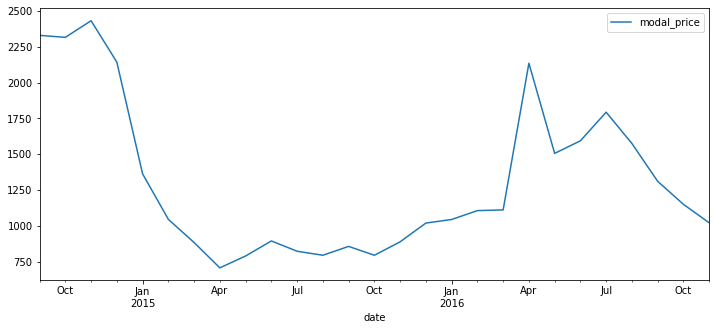

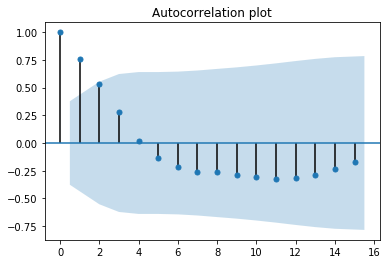

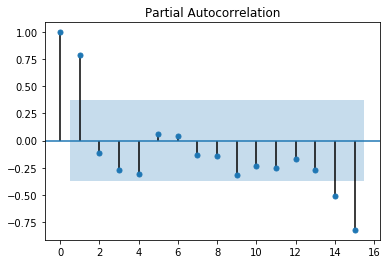

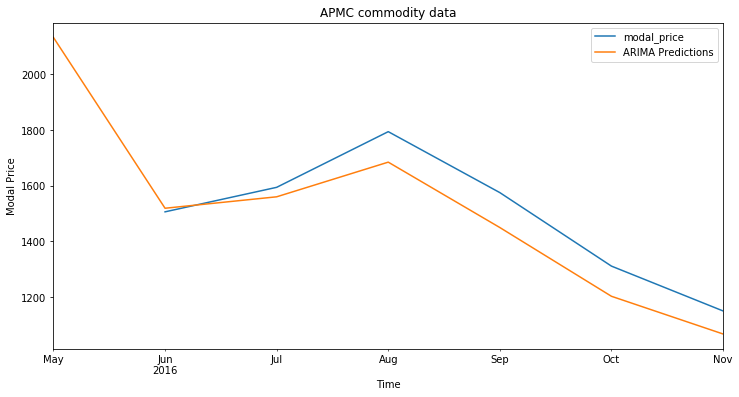

In [11]:
# Input the APMC and Commodity you want to analyse
apmc = input("Enter an APMC: ")
commodity = input("Enter a relevant commodity: ")
dataplot(apmc,commodity)

In [11]:
#help(auto_arima)